In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.layers import TimeDistributed
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras import optimizers

from Bio import SeqIO
from Bio.Data import IUPACData 
import csv
import numpy as np
import tensorflow as tf
import dask.dataframe as dd
import os.path
from matplotlib import pyplot

#data_path = 'features_CENH3_DMR6_LUCA-CHLRE00002_orthologues.csv'
data_path = 'features_oma-seqs-viridiplantae_test-3-4-5-6-7-8-9-10-11.csv'
data_single_cluster_path = 'features_oma-seqs-viridiplantae_test-1.csv'
#data_path = 'features_oma-seqs-viridiplantae_test-9-10-11.csv'
#data_path = 'features_oma-seqs-viridiplantae_test-11.csv'
#data_single_cluster_path = 'no_single_cluster.csv'

Using TensorFlow backend.


In [2]:
def protein2integer(in_seq):
    
    ## define universe of possible input values
    all_protein_letters = list(IUPACData.extended_protein_letters)
    #print(all_protein_letters)
    ## define a mapping of chars to integers 
    ## i+1 beacuse we want to start from integer 1 instead of 0. 0 will be used for padding
    char_to_int = dict((c, i+1) for i, c in enumerate(all_protein_letters))
    int_to_char = dict((i+1, c) for i, c in enumerate(all_protein_letters))
    ## integer encode input data
    integer_encoded = [char_to_int[char] for char in in_seq.upper()]
    
    
    #return(integer_encoded,len(all_protein_letters))
    return(integer_encoded)
    

In [3]:
def make_dataset(in_file):
    with open(in_file, 'r') as f:
        reader = csv.reader(f, delimiter="\t")
        # get all the rows as a list
        d_set = list(reader)
        # transform data into numpy array
        d_set = np.array(d_set).astype(str)
        
    integer_encoded_proteins = np.array([protein2integer(seq) for seq in d_set[:,1]])
    
    G = d_set[:, 0]
    X = integer_encoded_proteins
    Y = d_set[:, 2].astype(int)
                         
    return(d_set,G,X,Y)

In [4]:
def make_dataset_single(in_file,y_value=100000):
    with open(in_file, 'r') as f:
        reader = csv.reader(f, delimiter="\t")
        # get all the rows as a list
        d_set = list(reader)
        # transform data into numpy array
        d_set = np.array(d_set).astype(str)
        
    integer_encoded_proteins = np.array([protein2integer(seq) for seq in d_set[:,1]])
    
    G = d_set[:, 0]
    X = integer_encoded_proteins
    Y = np.full((len(d_set[:, 2]),1), int(y_value))[:,0]      
                         
    return(d_set,G,X,Y)

In [5]:
def make_dataset_dask(in_file):
    data = dd.read_csv(in_file,sep='\t', header=None)
    df = data.compute().reset_index(drop=True)
    integer_encoded_proteins = da.from_array([protein2integer(seq) for seq in df.values[:,1]],chunks=1000)
    G = df.values[:,0]
    X = integer_encoded_proteins.compute()
    Y = df.values[:,2].astype(int)
                     
    return(df,G,X,Y)

In [6]:
def make_train_test_set_idea1(G,X,Y):
    
    # here we keep 80% of random indexes in train set and the rest in test set
    
    indices = np.random.permutation(X.shape[0])
    train_size = int(indices.size*0.95)
    train_idx, test_idx = indices[:train_size], indices[train_size:]
    #print(len(train_idx),len(test_idx))
    
    X_train, X_test = X[train_idx,], X[test_idx,]
    #print(X_train.shape,X_test.shape)
    
    y_train, y_test = Y[train_idx,], Y[test_idx,]
    
    #print(X[train_idx[0],])
    #print(Y[train_idx[0],])

    #print(X_train[0,])
    #print(y_train[0,])
    
    return(X_train,y_train,X_test,y_test)

In [7]:
def make_train_test_set_idea2(G,X,Y):
    
    # here we try to keep one item from each cluster in test set
    # the rest goes to train set
    
    test_idx = []
    train_idx = []
    seen_cluster_id = []
    
    for i in range(0,Y.shape[0]):
            if Y[i] in seen_cluster_id :
                train_idx.append(i)
            else:
                test_idx.append(i)
                seen_cluster_id.append(Y[i])
                
    #print(len(train_idx),len(test_idx))
    
    X_train, X_test = X[train_idx,], X[test_idx,]
    #print(X_train.shape,X_test.shape)
    
    y_train, y_test = Y[train_idx,], Y[test_idx,]
    
    #print(X[train_idx[0],])
    #print(Y[train_idx[0],])

    #print(X_train[0,])
    #print(y_train[0,])
    
    return(X_train,y_train,X_test,y_test)

In [8]:
def model1(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10,model_json_file="model.json",model_h5_file="model.h5"): # RNN: Recurrent Neural Networks
    # https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)

    # create the model
    embedding_vecor_length = 4
    model = Sequential()
    model.add(Embedding(num_letters, embedding_vecor_length, input_length=fixed_seq_length))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(75))
    model.add(Dense(n_classes, activation='softmax'))

    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()

    # serialize model to JSON
    model_json = model.to_json()
    with open(model_json_file, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_h5_file)
    print("Saved model to disk")
    
    return()


In [9]:
def model2(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10): # RNN: Recurrent Neural Networks
    # Initializing the Sequential model from KERAS.
    model = Sequential()

    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)

    # Creating a 16 neuron hidden layer with Linear Rectified activation function.
    #model.add(Dense(16, input_dim=1, init='uniform', activation='relu'))
    model.add(Dense(16, input_dim=fixed_seq_length, kernel_initializer='uniform', activation='relu'))

    # Creating a 8 neuron hidden layer.
    model.add(Dense(8, kernel_initializer='uniform', activation='relu'))

    # Adding a output layer.
    model.add(Dense(n_classes, kernel_initializer='uniform', activation='softmax'))
    
    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    
    return()

In [10]:
def one_hot_matrix(labels,C):
    
    C = tf.constant(C,name="C")
    one_hot_matrix = tf.one_hot(labels,C,axis=1)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    
    return one_hot

In [11]:
def model3(X_train_new, y_train,X_test_new, y_test, batch_size =100, hm_epochs =100): # CNN: Convolutional Neural Networks
    # Number of nodes in each NN hidden layer
    n_nodes_hl1 = 1500
    n_nodes_hl2 = 1500
    n_nodes_hl3 = 1500

    # Number of orthology clusters
    #n_classes = len(np.unique(np.concatenate((y_train,y_test),axis=0)))     #2 or 3 or ...
    
    #y_all = np.concatenate((y_train,y_test),axis=0)
    #y_min = np.amin(y_all)
    #n_classes = np.amax(y_all-y_min)+1
    
    
    train_y = one_hot_matrix(y_train,n_classes)
    test_y = one_hot_matrix(y_test,n_classes)

    # Batch size and Epoch size for training the NN
    #batch_size = 100   #100
    #hm_epochs = 100    #1000

    # Initializing X and Y
    x = tf.placeholder('float')
    y = tf.placeholder('float')

    # Initializing NN layers
    hidden_1_layer = {'f_fum':n_nodes_hl1,
                  'weight':tf.Variable(tf.random_normal([len(X_train_new[0]), n_nodes_hl1])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'f_fum':n_nodes_hl2,
                  'weight':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'f_fum':n_nodes_hl3,
                  'weight':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                  'bias':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_layer = {'f_fum':None,
                'weight':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                'bias':tf.Variable(tf.random_normal([n_classes])),}


    
    
    l1 = tf.add(tf.matmul(x,hidden_1_layer['weight']), hidden_1_layer['bias'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weight']), hidden_2_layer['bias'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weight']), hidden_3_layer['bias'])
    l3 = tf.nn.relu(l3)

    prediction = tf.matmul(l3,output_layer['weight']) + output_layer['bias']

        
    cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y) )
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #try:
        #    epoch = int(open(tf_log,'r').read().split('\n')[-2])+1
        #    print('STARTING:',epoch)
        #except:
        #    epoch = 1
        epoch = 1

        while epoch <= hm_epochs:
            epoch_loss = 1
            
            i=0
            while i < len(X_train_new):
                start = i
                end = i+batch_size
                batch_x = np.array(X_train_new[start:end])
                batch_y = np.array(train_y[start:end])

                _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,y: batch_y})
                epoch_loss += c
                i+=batch_size
                
            
            print('Epoch ',epoch,' out of ',hm_epochs,'- loss:',epoch_loss)
 
            
            #with open(tf_log,'a') as f:
            #    f.write(str(epoch)+'\n') 
            epoch +=1
            
        correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

        #print("\nModel saved in path: %s " % my_model_save_path)
        print('\nAccuracy:',accuracy.eval({x:X_test_new, y:test_y}) * 100)
    return()

In [12]:
def model4(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10): 
    # RNN: Recurrent Neural Networks
    
    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)

    # create the model    
    model = Sequential()
    model.add(Embedding(num_letters, output_dim=fixed_seq_length))
    model.add(Dropout(0.25))
    model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
    model.add(MaxPooling1D(4))
    model.add(LSTM(70))
    model.add(Dense(n_classes, activation='softmax'))
    
    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    
  
    return()


In [13]:
def model5(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10,model_json_file="model.json",model_h5_file="model.h5"): # RNN: Recurrent Neural Networks
    # LSTM
    
    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)

    # create the model    
    model = Sequential()
    model.add(Embedding(num_letters, output_dim=fixed_seq_length))
    model.add(LSTM(500,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(250,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(125,return_sequences=True))
    model.add(Dropout(0.25))
    model.add(LSTM(75,return_sequences=True))
    model.add(LSTM(25))
    #model.add(Dropout(0.25))
    model.add(Dense(n_classes, activation='softmax'))
    
    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_json_file, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_h5_file)
    print("Saved model to disk")

    return()


In [14]:
def model6(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10): # RNN: Recurrent Neural Networks
    # GRU
    
    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)
    
    # create the model    
    model = Sequential()
    model.add(Embedding(num_letters, output_dim=fixed_seq_length))
    model.add(GRU(128, return_sequences=False))
    model.add(Dense(n_classes, activation='softmax'))

    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    
    return()


In [15]:
def use_model(model_json_file="model.json",model_h5_file="model.h5"):
    # load json and create model
    json_file = open(model_json_file, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(model_h5_file)
    print("Loaded model from disk")
 
    # evaluate loaded model on test data
    loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    score = loaded_model.evaluate(X, Y, verbose=0)
    print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))
    
    return()

In [16]:
def model7(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10,model_json_file="model.json",model_h5_file="model.h5"): # RNN: Recurrent Neural Networks
    # GRU
    
    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)
    
    # create the model    
    model = Sequential()
    model.add(Embedding(num_letters, output_dim=fixed_seq_length))
    model.add(GRU(128, return_sequences=False))
    model.add(Dense(n_classes, activation='softmax'))

    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
 
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_json_file, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_h5_file)
    print("Saved model to disk")
    
    return()


In [17]:
def model8(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10,model_json_file="model.json",model_h5_file="model.h5"): # RNN: Recurrent Neural Networks
    # https://keras.io/getting-started/sequential-model-guide/

    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)

    # create the model
    embedding_vecor_length = 4
    model = Sequential()
    model.add(Embedding(num_letters, embedding_vecor_length, input_length=fixed_seq_length))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    model.add(Conv1D(filters=512, kernel_size=3, activation='relu'))
    #model.add(GlobalAveragePooling1D())
    model.add(Dropout(0.25))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.25))
    
    model.add(MaxPooling1D(pool_size=2))
    #model.add(GRU(128, return_sequences=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(256,return_sequences=False))
        
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    
    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()

    # serialize model to JSON
    model_json = model.to_json()
    with open(model_json_file, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_h5_file)
    print("Saved model to disk")
    
    return()


In [18]:
def model9(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10,model_json_file="model.json",model_h5_file="model.h5"): # RNN: Recurrent Neural Networks
    # https://keras.io/getting-started/sequential-model-guide/

    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)

    # create the model
    embedding_vecor_length = 4
    model = Sequential()
    model.add(Embedding(num_letters, embedding_vecor_length, input_length=fixed_seq_length))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(3)))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(3)))
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Conv1D(filters=256, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(3)))
    model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu')))
    #model.add(GlobalAveragePooling1D())
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Dense(4096, activation='relu')))
    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Dense(4096, activation='relu')))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    #model.add(GRU(128, return_sequences=True))
    model.add(LSTM(128,return_sequences=True))
    model.add(LSTM(256,return_sequences=False))
        
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    
    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()

    # serialize model to JSON
    model_json = model.to_json()
    with open(model_json_file, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_h5_file)
    print("Saved model to disk")
    
    return()


In [19]:
def model10(X_train_new, y_train,X_test_new, y_test,in_batch_size=100,in_epochs=10,model_json_file="model.json",model_h5_file="model.h5"): # RNN: Recurrent Neural Networks
    # LSTM
    
    # Convert labels to categorical one-hot encoding  
    y_train_one_hot_labels = to_categorical(y_train, num_classes=n_classes)
    y_test_one_hot_labels = to_categorical(y_test, num_classes=n_classes)

    # create the model    
    model = Sequential()
    model.add(Embedding(num_letters, output_dim=fixed_seq_length))
    model.add(LSTM(75,return_sequences=True))
    model.add(LSTM(25))
    model.add(Dropout(0.25))
    model.add(Dense(16, input_dim=fixed_seq_length, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(n_classes, kernel_initializer='uniform', activation='softmax'))
    
    #opt = 'rmsprop'
    #opt = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    #opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=0.001, decay=0.0)
    #opt = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
    #opt = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
    opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #opt = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

    model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])
    print(model.summary())

    # fit the model
    history = model.fit(X_train_new, y_train_one_hot_labels, epochs=in_epochs, batch_size=in_batch_size,validation_data=(X_test_new, y_test_one_hot_labels), verbose=1)

    # evaluate the model
    train_loss, train_acc = model.evaluate(X_train_new, y_train_one_hot_labels, verbose=0)
    test_loss, test_acc = model.evaluate(X_test_new, y_test_one_hot_labels, verbose=0)
    print('Loss     ======= Train: %.3f, Test: %.3f' % (train_loss, test_loss))
    print('Accuracy ======= Train: %.3f, Test: %.3f' % (train_acc, test_acc))

    # list all data in history
    
    print(history.history.keys())
    # summarize history for accuracy
    pyplot.plot(history.history['acc'])
    pyplot.plot(history.history['val_acc'])
    pyplot.title('model accuracy')
    pyplot.ylabel('accuracy')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    # summarize history for loss
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history['val_loss'])
    pyplot.title('model loss')
    pyplot.ylabel('loss')
    pyplot.xlabel('epoch')
    pyplot.legend(['train', 'test'], loc='upper left')
    pyplot.show()
    
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_json_file, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_h5_file)
    print("Saved model to disk")

    return()


In [20]:
def test_1(d_set):
    print(d_set[:,0])
    print(d_set[0:2,1])
    print(d_set[:,2].astype(int))
    print(d_set.shape)
    print(d_set[:,1].shape)
    return()

In [21]:
def test_2(d_set):
    integer_encoded_proteins = np.array([protein2integer(seq) for seq in d_set[:,1]])
    print(len(integer_encoded_proteins))
    print(integer_encoded_proteins[0])
    #np.array(integer_encoded_proteins).shape
    print(integer_encoded_proteins.shape)
    #protein2integer(dataset[:,1])
    return()

In [22]:
def test_3(G,X,Y):
    print(G.shape)
    print(X.shape)
    print(Y.shape)

    print(G[0:3,])
    print(X[0:3,])
    print(Y[0:3,])
    
    print('Maximum sequence length: {}'.format(len(max(X, key=len))))
    print('Minimum sequence length: {}'.format(len(min(X, key=len))))
    
    return()

In [23]:
def test_4(X_train_new,X_train):
    print(X_train_new.shape)
    print(X_train_new[0,:])
    print(X_train.shape)
    print(X_train[0,])
    return()


In [24]:
dataset, G, X, Y = make_dataset(data_path)
X_train,y_train,X_test,y_test = make_train_test_set_idea2(G,X,Y)

if (os.path.exists(data_single_cluster_path)):
    n_classes = int(np.amax(np.concatenate((y_train,y_test),axis=0))+1)
    make_dataset_single(data_single_cluster_path,n_classes+1)
    dataset, G, X, Y = make_dataset_single(data_single_cluster_path,n_classes+1)
    X_train_s,y_train_s,X_test_s,y_test_s = make_train_test_set_idea1(G,X,Y)

    X_train = np.concatenate((X_train,X_train_s),axis=0)
    X_test = np.concatenate((X_test,X_test_s),axis=0)
    y_train = np.concatenate((y_train,y_train_s),axis=0)
    y_test = np.concatenate((y_test,y_test_s),axis=0)

#print("============ Test 1 =======================")
#test_1(dataset)
#print("============ Test 2 =======================")
#test_2(dataset)
#print("============ Test 3 =======================")
#test_3(G,X,Y)
#print("============ Test 4 =======================")
#test_4(X_train,X_test)



In [25]:
num_letters = len(list(IUPACData.extended_protein_letters)) # = 26
#fixed_seq_length = len(max(X, key=len)) # maximum
fixed_seq_length = (sum(len(X[i,]) for i in range(X.shape[0]))/X.shape[0])  # average ~490
#fixed_seq_length = 1000
n_classes = int(np.amax(np.concatenate((y_train,y_test),axis=0))+1)
# truncate and pad input sequences
X_train_new = sequence.pad_sequences(X_train, maxlen=fixed_seq_length, padding='post', truncating='post')
X_test_new = sequence.pad_sequences(X_test, maxlen=fixed_seq_length, padding='post', truncating='post')
  
#print("============ Test 4 =======================")
#test_4(X_train_new,X_train)

#all_length = []
#for i in range(X.shape[0]):
#    all_length.append(len(X[i,]))
#fixed_seq_length = np.median(all_length)  # median ~394

print(fixed_seq_length)

418


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 418, 4)            104       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 418, 32)           416       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 209, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 75)                32400     
_________________________________________________________________
dense_1 (Dense)              (None, 31273)             2376748   
Total params: 2,409,668
Trainable params: 2,409,668
Non-trainable params: 0
_________________________________________________________________
None
Train on 35746 samples, validate on 9044 samples
Epoch 1/10
35746/35746 [==============================] - 106s 3ms/step - loss

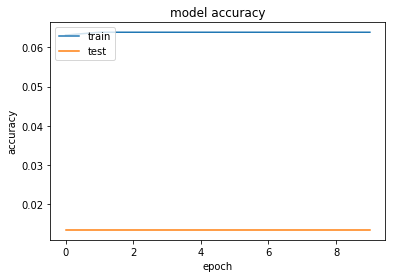

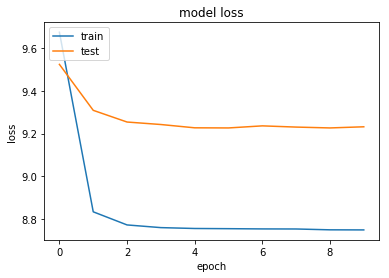

Saved model to disk


()

In [26]:
model1(X_train_new, y_train, X_test_new, y_test,256,10,"results/CNV_LSTM_model_test.json",model_h5_file="results/CNV_LSTM_model_test.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                6704      
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_8 (Dense)              (None, 31273)             281457    
Total params: 288,297
Trainable params: 288,297
Non-trainable params: 0
_________________________________________________________________
None
Train on 35746 samples, validate on 9044 samples
Epoch 1/100
35746/35746 [==============================] - 42s 1ms/step - loss: 9.6841 - acc: 0.0493 - val_loss: 9.4511 - val_acc: 0.0134
Epoch 2/100
35746/35746 [==============================] - 40s 1ms/step - loss: 8.7911 - acc: 0.0639 - val_loss: 9.2225 - val_acc: 0.0134
Epoch 3/100
35746/35746 [==============================] - 39s 1ms/ste

35746/35746 [==============================] - 38s 1ms/step - loss: 6.8537 - acc: 0.0620 - val_loss: 8.6073 - val_acc: 0.0127
Epoch 55/100
35746/35746 [==============================] - 38s 1ms/step - loss: 6.8447 - acc: 0.0618 - val_loss: 8.6016 - val_acc: 0.0130
Epoch 56/100
35746/35746 [==============================] - 39s 1ms/step - loss: 6.8344 - acc: 0.0622 - val_loss: 8.6461 - val_acc: 0.0130
Epoch 57/100
35746/35746 [==============================] - 39s 1ms/step - loss: 6.8240 - acc: 0.0613 - val_loss: 8.7037 - val_acc: 0.0129
Epoch 58/100
35746/35746 [==============================] - 42s 1ms/step - loss: 6.8182 - acc: 0.0616 - val_loss: 8.6915 - val_acc: 0.0138
Epoch 59/100
35746/35746 [==============================] - 39s 1ms/step - loss: 6.8099 - acc: 0.0623 - val_loss: 8.7143 - val_acc: 0.0127
Epoch 60/100
35746/35746 [==============================] - 41s 1ms/step - loss: 6.7961 - acc: 0.0619 - val_loss: 8.7100 - val_acc: 0.0129
Epoch 61/100
35746/35746 [==============

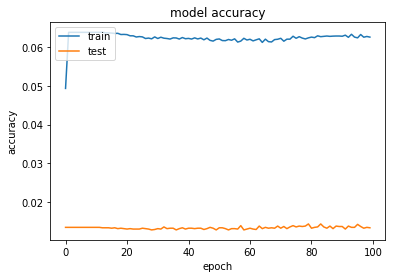

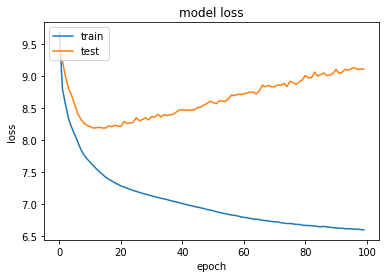

()

In [33]:
model2(X_train_new, y_train, X_test_new, y_test,256,100)

In [28]:
#model3(X_train_new, y_train, X_test_new, y_test,256,10)

In [29]:
#model4(X_train_new, y_train, X_test_new, y_test,256,100)

In [30]:
#model5(X_train_new, y_train, X_test_new, y_test,128,100,"results/LSTM_model_test.json",model_h5_file="results/LSTM_model_test.h5")

In [31]:
##model6(X_train_new, y_train, X_test_new, y_test,256,10)

In [ ]:
model7(X_train_new, y_train, X_test_new, y_test,256,100,"results/GRU_model_test.json",model_h5_file="results/GRU_model_test.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 418)         10868     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               210048    
_________________________________________________________________
dense_12 (Dense)             (None, 31273)             4034217   
Total params: 4,255,133
Trainable params: 4,255,133
Non-trainable params: 0
_________________________________________________________________
None
Train on 35746 samples, validate on 9044 samples
Epoch 1/100
22784/35746 [==================>...........] - ETA: 2:17 - loss: 9.8336 - acc: 0.0630

In [ ]:
#model8(X_train_new, y_train, X_test_new, y_test,8,10,"results/CNV_LSTM_XL_model_test.json",model_h5_file="results/CNV_LSTM_XL_model_test.h5")

In [ ]:
#model9(X_train_new, y_train, X_test_new, y_test,8,10,"results/CNV_LSTM_XL_model_test.json",model_h5_file="results/CNV_LSTM_XL_model_test.h5")

In [34]:
model10(X_train_new, y_train, X_test_new, y_test,256,50,"results/LSTM_model_test.json",model_h5_file="results/LSTM_model_test.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 418)         10868     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 75)          148200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                416       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 31273)             281457    
Total para

KeyboardInterrupt: 